## Chocolate Classification using DL

#### Imports:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import cv2
import shutil
from shutil import copyfile
import random

import keras
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator # from keras.preprocessing.image import ImageDataGenerator is deprecated
from sklearn.model_selection import train_test_split
from keras.utils import load_img, img_to_array
from tensorflow import keras
from keras.applications.vgg16 import VGG16
from keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, MaxPooling2D, BatchNormalization, Activation, Dropout, Flatten, Conv2D
from keras.models import Model
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#### Plot history:

In [25]:
# function to plote training history
def plot_history(history):
    # store results
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # plot results
    # accuracy
    plt.figure(figsize=(5, 8))
    plt.rcParams['figure.figsize'] = [8, 4]
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.facecolor'] = 'white'
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(round(acc[-1],3))}\nValidation Accuracy: {str(round(val_acc[-1],3))}')
    
    # loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title(f'Training and Validation Loss. \nTrain Loss: {str(round(loss[-1],3))}\nValidation Loss: {str(round(val_loss[-1],3))}')
    plt.xlabel('epoch')
    plt.tight_layout(pad=3.0)
    plt.show()

#### Setting up the data:

In [ ]:
train_dir = '../Dataset/train/'
test_dir = '../Dataset/test/'

In [ ]:
# show the number of images in each class
for i in os.listdir(train_dir):
    print(f'{i}: {len(os.listdir(train_dir + i))}')

# show the number of images in each class
for i in os.listdir(test_dir):
    print(f'{i}: {len(os.listdir(test_dir + i))}')

In [ ]:
# plot the bar chart
plt.figure(figsize=(10, 5))
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['font.size'] = 10
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.bar(os.listdir(train_dir), [len(os.listdir(train_dir + i)) for i in os.listdir(train_dir)])
plt.title('Number of Images in Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


In [ ]:
#use generators
#resize image
train_ds = keras.utils.image_dataset_from_directory(
    directory=train_dir,
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256,256)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory=test_dir,
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256,256)
)

In [ ]:
def process(image, label):
    image = tf.cast(image/255,tf.float32)
    return image, label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

#### Approach 1: CNN

In [ ]:
# Model Definition
INPUT_SHAPE = (256, 256, 3)

model = keras.Sequential()

model.add(Conv2D(32, (3, 3), input_shape = INPUT_SHAPE))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))


In [ ]:
model.compile(loss='binary_crossentropy',
             optimizer='Adam',
             metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
history = model.fit(train_ds,
                  batch_size = 32,
                  verbose=1,
                  epochs=20,
                  validation_data=validation_ds,
                  shuffle=False)

In [ ]:
plot_history(history)

In [ ]:
_, acc = model.evaluate(validation_ds)
print("Accuracy: ", (acc*100.0), " %")

#### Approach 2: VGG16

In [ ]:
# Load the pre-trained VGG19 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False
# Add custom classification layers on top of the pre-trained model
last_output = base_model.output
x = tf.keras.layers.Flatten()(last_output)  # Flatten the output layer to 1 dimension
x = tf.keras.layers.Dense(1024, activation='relu')(x)   # Add a fully connected layer with 1024 hidden units and ReLU activation
x = tf.keras.layers.Dropout(0.6)(x) # Add dropout for regularization
predictions = Dense(1, activation='sigmoid')(x)  # 2 classes: cat and dog

In [ ]:
# Create the final model
vgg16_model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
vgg16_model.summary()

In [ ]:
vgg16_model.compile(optimizer = tf.keras.optimizers.legacy.Adam(),
            loss = 'binary_crossentropy',
            metrics=['accuracy'])

In [ ]:
# Train the model
history = vgg16_model.fit(train_ds,
                       epochs=25,
                       validation_data=validation_ds,
                       verbose=1)

In [ ]:
plot_history(history)

#### Approach 3: ResNet50

In [ ]:
# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False
# Add custom classification layers on top of the pre-trained model
last_output = base_model.output 
x = tf.keras.layers.Flatten()(last_output)  # Flatten the output layer to 1 dimension
x = tf.keras.layers.Dense(1024, activation='relu')(x)   # Add a fully connected layer with 1024 hidden units and ReLU activation
x = tf.keras.layers.Dropout(0.6)(x) # Add dropout for regularization
predictions = Dense(1, activation='sigmoid')(x)  # 2 classes: cats and dogs

In [ ]:
# create the final model
resnet50_model = Model(inputs=base_model.input, outputs=predictions)
resnet50_model.summary()

In [ ]:
resnet50_model.compile(optimizer = tf.keras.optimizers.legacy.Adam(),
            loss = 'binary_crossentropy',
            metrics=['accuracy'])

In [ ]:
# Train the model
resnet50_history = model.fit(train_ds,
                       epochs=20,
                       validation_data=validation_ds,
                       verbose=1)

In [ ]:
plot_history(resnet50_history)

#### 4. CNN with Attention mechanism

In [26]:
# importing modules and libraries

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.layers import Input, InputLayer, Conv2D, MaxPooling2D, Flatten, ELU, Dense, BatchNormalization, Dropout
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.optimizers import Nadam

In [27]:
from pathlib import Path
import imghdr

data_dir = "..\Dataset\Chocolate Classification"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

..\Dataset\Chocolate Classification\Dark Chocolate\Image_140.jpg is a webp, not accepted by TensorFlow
..\Dataset\Chocolate Classification\White Chocolate\Image_10.jpg is a webp, not accepted by TensorFlow
..\Dataset\Chocolate Classification\White Chocolate\Image_56.jpg is a webp, not accepted by TensorFlow


In [28]:
import os

dataset_dir = '..\Dataset\Chocolate Classification'

extensions = [".png", ".jpg", ".jpeg"]

images_list = []
labels_list = []

image_size = (64, 64)

for folder_name in os.listdir(dataset_dir):
    folder_path = os.path.join(dataset_dir, folder_name)
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            if file_name.lower().endswith(tuple(extensions)):
                actual_format = imghdr.what(file_path)
                if actual_format == 'webp':
                    continue

                image_data = tf.io.read_file(file_path)
                image = tf.image.decode_jpeg(image_data, channels=3)

                image = tf.image.resize(image, image_size)

                image = tf.cast(image / 255.0, tf.float32)

                label = folder_name

                images_list.append(image.numpy())
                labels_list.append(label)

images = np.array(images_list)
labels = np.array(labels_list)

In [29]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()

labels = encoder.fit_transform(labels.reshape(-1, 1))

In [30]:
from sklearn.model_selection import train_test_split # splitting data for training

x_train, x_temp, y_train, y_temp = train_test_split(images,labels,test_size=0.5,random_state=42)

x_test, x_val, y_test, y_val = train_test_split(x_temp,y_temp,test_size=0.5)

# train:val:test ratio : 60:20:20

# shapes of data

print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)
print("x_val:", x_val.shape)
print("y_val:", y_val.shape)

x_train: (67, 64, 64, 3)
y_train: (67, 1)
x_test: (33, 64, 64, 3)
y_test: (33, 1)
x_val: (34, 64, 64, 3)
y_val: (34, 1)


In [81]:
from keras.models import Model
from keras.layers import Multiply
from keras.regularizers import l2

def attention_mechanism(inputs): # Attention mechanism

    att_weights = Conv2D(1, kernel_size=(1, 1), activation='sigmoid')(inputs)

    attended_output = Multiply()([inputs, att_weights])
    
    return attended_output

# MOdel Checkpoint focused on val_accuracy to store best weights of max val_accuracy
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')

input_dim = Input(shape=(64, 64, 3)) # input layer

# Convolutional layers with BatchNormalization and MaxPooling
layer_1 = Conv2D(64, 3, activation=ELU(), padding='same', kernel_initializer = 'he_uniform')(input_dim)
x = BatchNormalization()(layer_1)
x = MaxPooling2D(pool_size=2, padding='same')(x)

x = attention_mechanism(x)

layer_2 = Conv2D(64, 3, activation=ELU(), padding='same', kernel_initializer = 'he_uniform', kernel_regularizer=l2(0.01))(x)
layer_2 = BatchNormalization()(layer_2)
x = MaxPooling2D(pool_size=2, padding='same')(layer_2)

x = attention_mechanism(x)

# Flatten layer to reshape data
x = Flatten()(x)

# Dense layers
layer_4 = Dense(64, activation='relu')(x)

layer_5 = Dense(1, activation='sigmoid')(layer_4)

model = Model(inputs=input_dim, outputs=layer_5) # setting model layers
model.summary() # summary of model

model.compile(optimizer=Nadam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy']) # compiling the model

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 64, 64,    │      1,792 │ input_layer_10[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 32, 32, 1) │         65 │ max_pooling2d_20… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_20         │ (None, 32, 32,    │          0 │ max_pooling2d_20… │
│ (Multiply)          │ 64)               │            │ conv2d_41[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 32, 32,    │     36,928 │ multiply_20[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_42[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 16, 16, 1) │         65 │ max_pooling2d_21… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_21         │ (None, 16, 16,    │          0 │ max_pooling2d_21… │
│ (Multiply)          │ 64)               │            │ conv2d_43[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 16384)     │          0 │ multiply_21[0][0] │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 64)        │  1,048,640 │ flatten_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 1)         │         65 │ dense_20[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,088,067 (4.15 MB)

 Trainable params: 1,087,811 (4.15 MB)

 Non-trainable params: 256 (1.00 KB)

In [82]:
# training model
history = model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=18, callbacks=[model_checkpoint],verbose=1,batch_size=5)

Epoch 1/18
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5422 - loss: 2.4166
Epoch 1: val_accuracy improved from -inf to 0.41176, saving model to model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.5654 - loss: 2.3699 - val_accuracy: 0.4118 - val_loss: 4.9890
Epoch 2/18
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9295 - loss: 1.6308
Epoch 2: val_accuracy did not improve from 0.41176
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9230 - loss: 1.6391 - val_accuracy: 0.4118 - val_loss: 5.6115
Epoch 3/18
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 1.2998
Epoch 3: val_accuracy did not improve from 0.41176
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 1.0000 - loss: 1.2976 - val_accuracy: 0.4118 - val_loss: 3.0391
Epoch 4/18
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 1.2132
Epoch 4: val_accuracy improved from 0.41176 to 0.47059, saving model to model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - acc

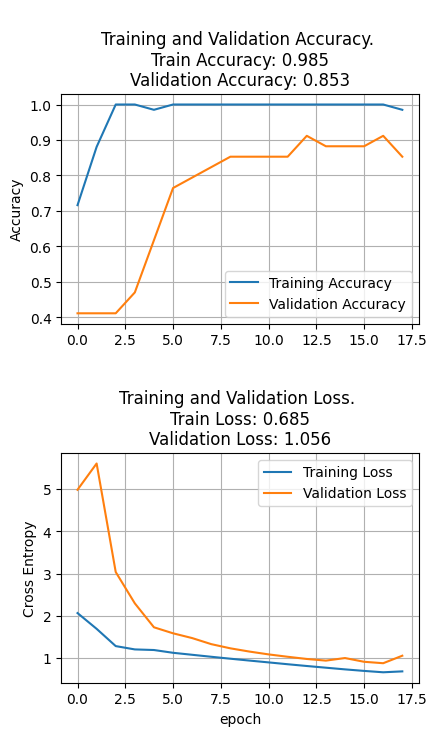

In [83]:
plot_history(history) # plotting graphs through function

In [84]:
import keras

model1 = keras.models.load_model('model.keras', custom_objects={"ELU": keras.layers.ELU}) # loading saved model

y_pred = model1.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


In [85]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, mean_squared_error

# Accuracy
accuracy = accuracy_score(y_test,y_pred_binary)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(y_test,y_pred_binary)
print("Precision:", precision)

# Recall
recall = recall_score(y_test,y_pred_binary)
print("Recall:", recall)

# F1 Score
f1 = f1_score(y_test,y_pred_binary)
print("F1 Score:", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test,y_pred_binary)
print("Confusion Matrix:\n", conf_matrix)

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test,y_pred_binary)
auc = roc_auc_score(y_test,y_pred_binary)
print("AUC:", auc)

Accuracy: 0.9696969696969697
Precision: 1.0
Recall: 0.9230769230769231
F1 Score: 0.9600000000000001
Confusion Matrix:
 [[20  0]
 [ 1 12]]
AUC: 0.9615384615384616
